In [1]:
import numpy as np
import pandas as pd
import yaml
import torch
from copy import deepcopy
import matplotlib.pyplot as plt
from celldreamer.eval.eval_utils import normalize_and_compute_metrics
import scipy.sparse as sp
from celldreamer.eval.eval_utils import join_real_generated

from torch import nn
import scanpy as sc    

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.fm.fm import FM
from celldreamer.eval.optimal_transport import wasserstein
import random
from celldreamer.models.base.encoder_model import EncoderModel
from celldreamer.models.base.utils import unsqueeze_right
from celldreamer.paths import DATA_DIR

device  = "cuda" if torch.cuda.is_available() else "cpu"

sc.set_figure_params(dpi=100, frameon=False, fontsize=12)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


**Util function**

In [2]:
dataset_config = {'dataset_path': DATA_DIR / 'processed_full_genome' / 'tabula_muris' / 'tabula_muris_test.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['mouse.id', 'tissue'],
                    'subsample_frac': 1,
                    'encoder_type': 'learnt_autoencoder',
                    'one_hot_encode_features': False,
                    'split_rates': [0.90, 0.10],
                    'cov_embedding_dimensions': 128, 
                    'multimodal': False, 
                    'is_binarized': False,
                    'theta_covariate': 'tissue', 
                    'size_factor_covariate': 'mouse.id',
                 }

data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                        layer_key=dataset_config["layer_key"],
                        covariate_keys=dataset_config["covariate_keys"],
                        subsample_frac=dataset_config["subsample_frac"], 
                        encoder_type=dataset_config["encoder_type"],
                        multimodal=dataset_config["multimodal"],
                        is_binarized=dataset_config["is_binarized"]
                      )

dataloader = torch.utils.data.DataLoader(dataset,
                                            batch_size=256,
                                            shuffle=True,
                                            num_workers=4, 
                                            drop_last=True)

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


## Step 2: Initialize encoder

In [3]:
encoder_config = {
    "x0_from_x_kwargs": {
        "dims": [512, 256, 100],
        "batch_norm": True,
        "dropout": False,
        "dropout_p": 0.0
    },
    "learning_rate": 0.001,
    "weight_decay": 0.00001,
    "covariate_specific_theta": False, 
    "multimodal": False,
    "is_binarized": False}


state_dict_path = "/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/off_train_autoencoder_tabula_muris_whole_genome/df8d1d1a-085d-403c-8323-beb4c5a3f4cd/checkpoints/epoch_79.ckpt"

In [4]:
encoder_model = EncoderModel(in_dim=in_dim,
                              n_cat=None,
                              conditioning_covariate=dataset_config["theta_covariate"], 
                              encoder_type=dataset_config["encoder_type"],
                              **encoder_config)

encoder_model.eval()

encoder_model.load_state_dict(torch.load(state_dict_path)["state_dict"])

<All keys matched successfully>

## Initialize FM model

In [5]:
generative_model_config = {'learning_rate': 0.0001,
                            'weight_decay': 0.00001,
                            'antithetic_time_sampling': True,
                            'sigma': 0.5}

In [6]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/UNGUIDED_MULTILAB_TABULA/4de85a96-f91e-4c25-aa29-0a26605d24e9/checkpoints/last.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]
denoising_model.multimodal = False

In [7]:
print(ckpt["hyper_parameters"]["feature_embeddings"]["tissue"].embeddings.weight)
feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

Parameter containing:
tensor([[ 1.3974,  1.0115,  1.3218,  ..., -0.5080, -0.3847, -0.3545],
        [-0.0095,  0.8149, -0.3686,  ..., -1.5997,  0.0889,  0.3801],
        [-0.6230,  0.1870, -0.1706,  ..., -1.0850,  0.6688,  1.3160],
        ...,
        [-0.4274,  0.3688, -0.2192,  ...,  1.7687, -1.3881, -2.9383],
        [ 0.7593,  1.4695,  0.6403,  ...,  0.7875, -0.7070, -2.0341],
        [-1.0819,  1.5817, -1.1036,  ...,  0.4742,  0.3446,  1.9353]],
       device='cuda:0', requires_grad=True)


Initializations

In [8]:
generative_model = FM(
            encoder_model=encoder_model,
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=50,
            size_factor_statistics=size_factor_statistics,
            covariate_list=dataset_config["covariate_keys"],
            theta_covariate=dataset_config["theta_covariate"],
            size_factor_covariate=dataset_config["size_factor_covariate"],
            model_type=denoising_model.model_type, 
            encoder_type=dataset_config["encoder_type"],
            multimodal=dataset_config["multimodal"],
            is_binarized=False,
            modality_list=None,
            guidance_weights={'tissue': 2, 'mouse.id': 2},
            **generative_model_config  # model_kwargs should contain the rest of the arguments
            )

generative_model.load_state_dict(ckpt["state_dict"])
generative_model.to("cuda")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


FM(
  (encoder_model): EncoderModel(
    (x0_from_x): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=19734, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=512, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (2): Linear(in_features=256, out_features=100, bias=True)
      )
    )
    (x_from_x0): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=100, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
       

**Check the data**

In [9]:
adata_original = sc.read_h5ad(data_path)
adata_original.obs["size_factor"]=adata_original.X.A.sum(1)
adata_original.X = adata_original.layers["X_counts"].A.copy()
X = torch.tensor(adata_original.layers["X_counts"].todense())

In [10]:
adata_original

AnnData object with n_obs × n_vars = 49078 × 19734
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'size_factor'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'neighbors', 'pca', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X_counts'
    obsp: 'connectivities', 'distances'

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


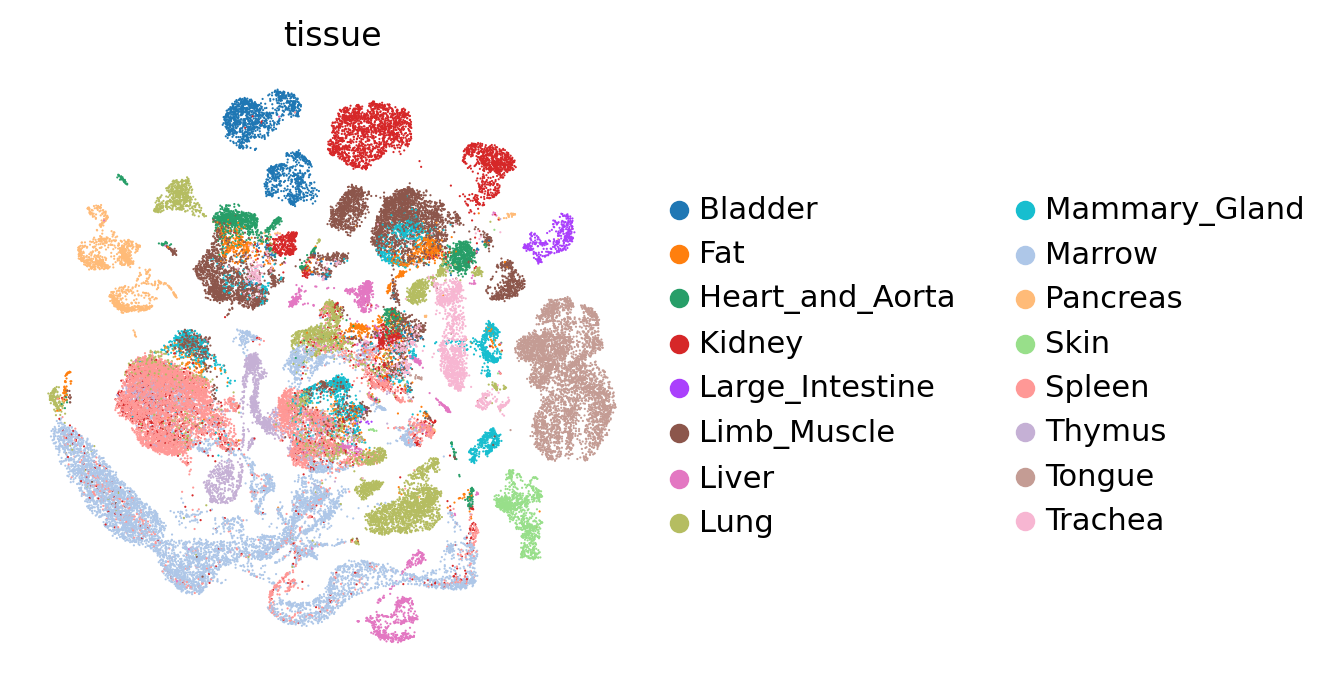

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


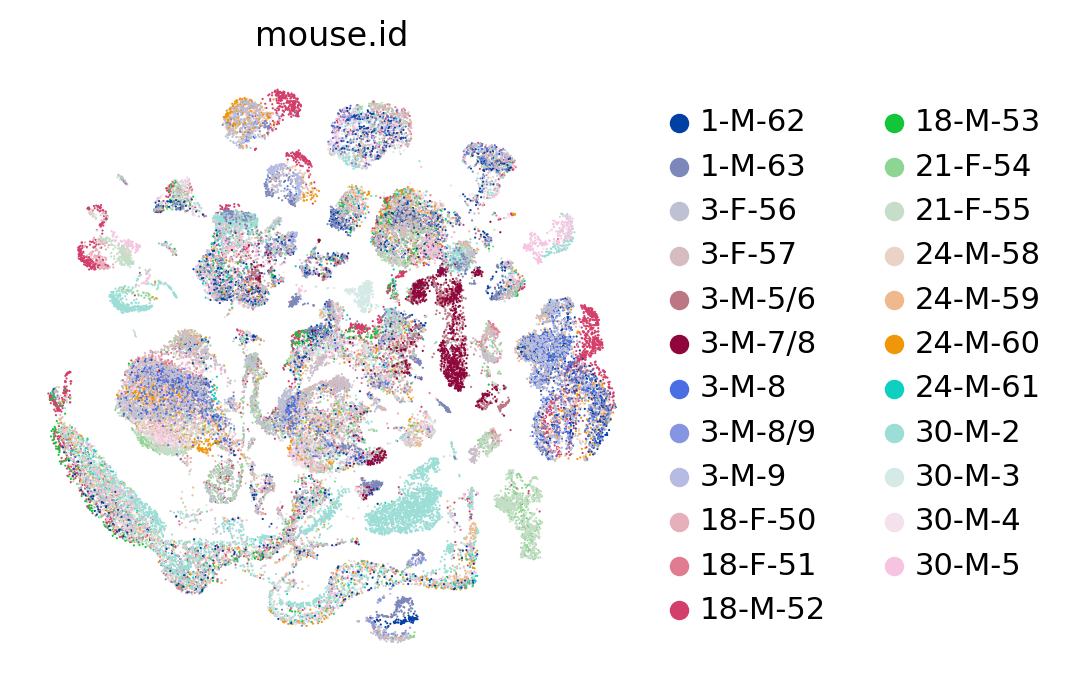

In [11]:
sc.pl.umap(adata_original, color="tissue")
sc.pl.umap(adata_original, color="mouse.id")

# COMBINATION OF CONDITIONS 

In [12]:
generative_model.guidance_weights

{'tissue': 2, 'mouse.id': 2}

In [13]:
dataset.id2cov["tissue"]

{'Bladder': 0,
 'Fat': 1,
 'Heart_and_Aorta': 2,
 'Kidney': 3,
 'Large_Intestine': 4,
 'Limb_Muscle': 5,
 'Liver': 6,
 'Lung': 7,
 'Mammary_Gland': 8,
 'Marrow': 9,
 'Pancreas': 10,
 'Skin': 11,
 'Spleen': 12,
 'Thymus': 13,
 'Tongue': 14,
 'Trachea': 15}

In [14]:
dataset.id2cov["mouse.id"]

{'1-M-62': 0,
 '1-M-63': 1,
 '18-F-50': 2,
 '18-F-51': 3,
 '18-M-52': 4,
 '18-M-53': 5,
 '21-F-54': 6,
 '21-F-55': 7,
 '24-M-58': 8,
 '24-M-59': 9,
 '24-M-60': 10,
 '24-M-61': 11,
 '3-F-56': 12,
 '3-F-57': 13,
 '3-M-5/6': 14,
 '3-M-7/8': 15,
 '3-M-8': 16,
 '3-M-8/9': 17,
 '3-M-9': 18,
 '30-M-2': 19,
 '30-M-3': 20,
 '30-M-4': 21,
 '30-M-5': 22}

In [15]:
pd.crosstab(adata_original.obs.tissue, adata_original.obs["mouse.id"])

mouse.id,1-M-62,1-M-63,3-F-56,3-F-57,3-M-5/6,3-M-7/8,3-M-8,3-M-8/9,3-M-9,18-F-50,...,21-F-54,21-F-55,24-M-58,24-M-59,24-M-60,24-M-61,30-M-2,30-M-3,30-M-4,30-M-5
tissue,,,,,,,,,,,,,,,,,,,,,
Bladder,0,207,107,0,0,0,26,0,361,0,...,0,0,281,197,193,0,0,0,0,0
Fat,0,0,0,0,0,0,0,0,0,278,...,82,67,0,0,0,0,0,0,0,400
Heart_and_Aorta,0,180,111,0,0,0,0,0,0,122,...,88,90,84,64,0,0,810,32,0,0
Kidney,278,237,0,216,0,0,105,0,166,152,...,212,225,592,555,0,0,360,261,289,217
Large_Intestine,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,101,0,77,206
Limb_Muscle,607,577,353,375,0,0,0,0,0,185,...,331,384,354,374,337,342,0,0,313,286
Liver,91,446,70,28,0,0,0,104,0,0,...,73,0,13,5,0,0,0,386,9,75
Lung,206,295,73,205,119,334,0,0,0,68,...,246,325,0,0,0,0,1570,328,190,104
Mammary_Gland,0,0,391,527,0,0,0,0,0,343,...,494,470,0,0,0,0,0,0,0,0


In [16]:
# Pick condition 
covariates_tissue = 'Bladder'
covariates_mouse_id = '3-F-56'

condition_id_clus = dataset.id2cov["tissue"][covariates_tissue]
condition_id_mouse_id = dataset.id2cov["mouse.id"][covariates_mouse_id]

adata_cond = adata_original[np.logical_and(adata_original.obs.tissue==covariates_tissue, 
                                           adata_original.obs["mouse.id"]==covariates_mouse_id)]
n_to_generate = adata_cond.shape[0]

classes = {"tissue": condition_id_clus*torch.ones(n_to_generate).long(), 
           "mouse.id": condition_id_mouse_id*torch.ones(n_to_generate).long()}

classes_str = {"tissue": [covariates_tissue for n in range(n_to_generate)], 
           "mouse.id": [covariates_mouse_id for n in range(n_to_generate)]}

log_size_factors = torch.log(torch.tensor(adata_cond.layers["X_counts"].sum(1))).cuda()

In [17]:
X_generated = generative_model.sample(batch_size=n_to_generate,
                                        n_sample_steps=100, 
                                        theta_covariate="a", 
                                        size_factor_covariate="mouse.id",
                                        conditioning_covariates=["tissue", "mouse.id"],
                                        covariate_indices=classes, 
                                        log_size_factor=None)

X_generated = X_generated.to("cpu")

adata_generated = sc.AnnData(X=X_generated.numpy())

In [18]:
adata_merged = join_real_generated(adata_original, adata_generated, True, classes_str, ["tissue", "mouse.id"])

In [19]:
X_generated.sum(1).max()

tensor(37212.)

In [20]:
X.sum(1).max()

tensor(135736.)

In [21]:
sc.pp.neighbors(adata_merged)
sc.tl.umap(adata_merged)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pynndescent/pynndescent_.py:346: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numba-captured-errors
Exception origin:
  File "/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/numba/core/types/functions.py", line 486, in __getnewargs__
    raise ReferenceError("underlying object has vanished")

  init_rp_tree(data, dist, current_graph, leaf_array)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pynndescent/pynndescent_.py:348: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style'

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python

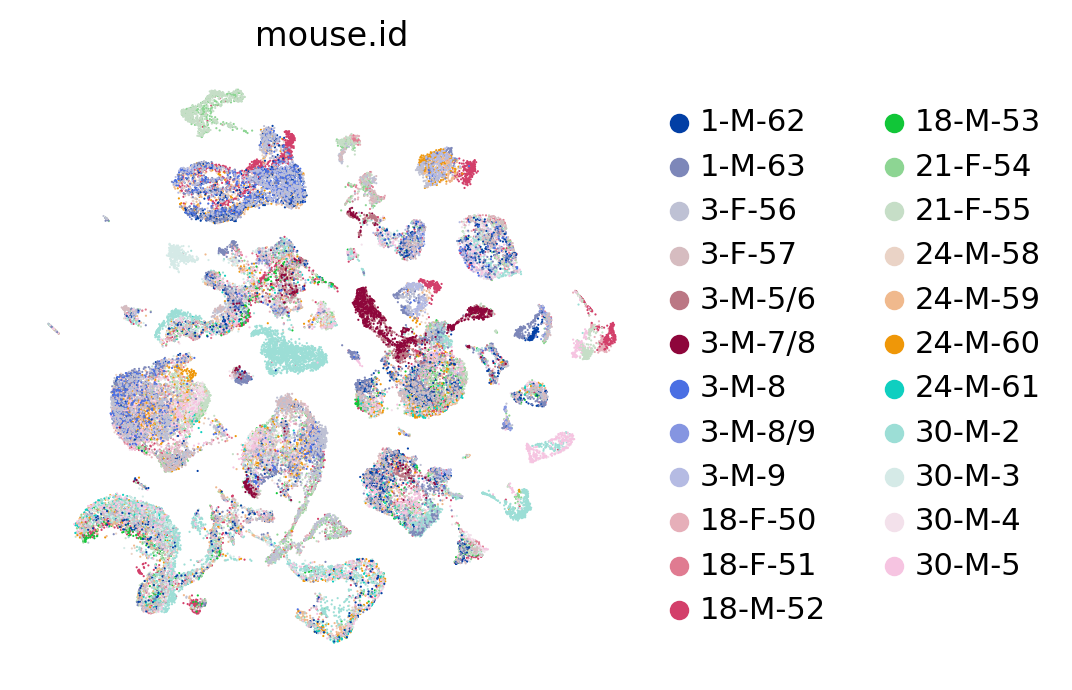

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python

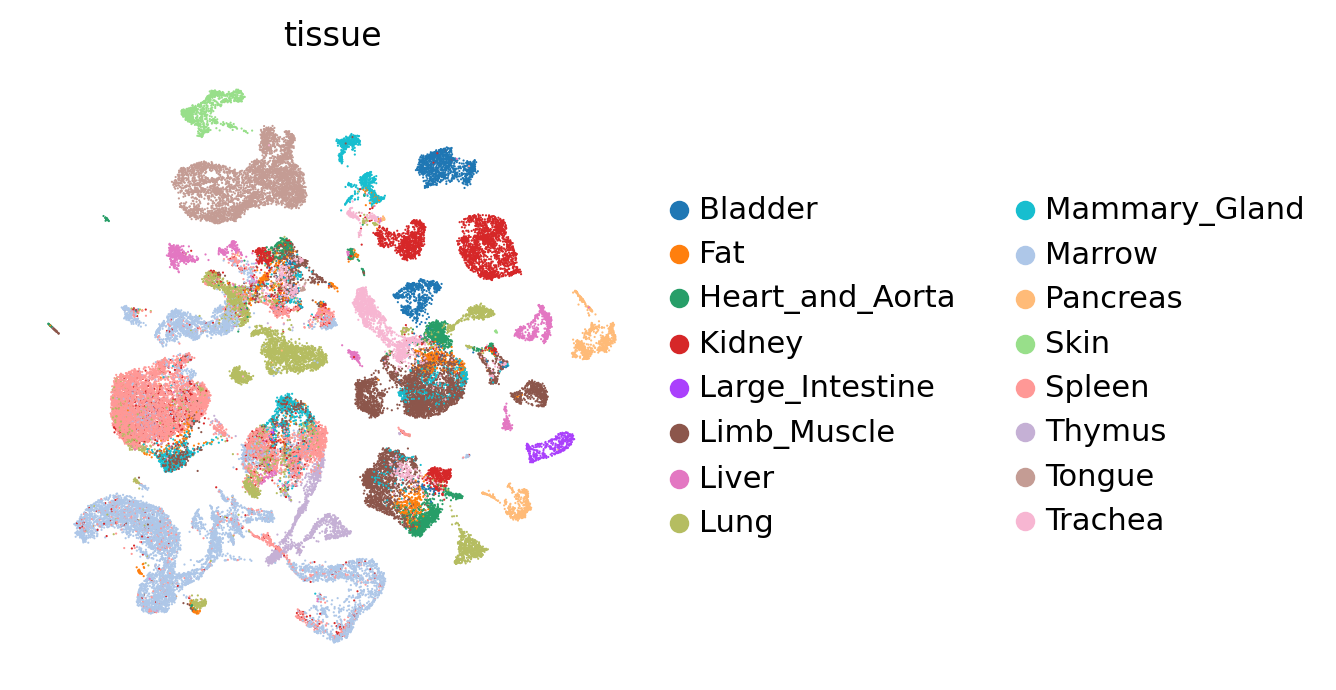

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


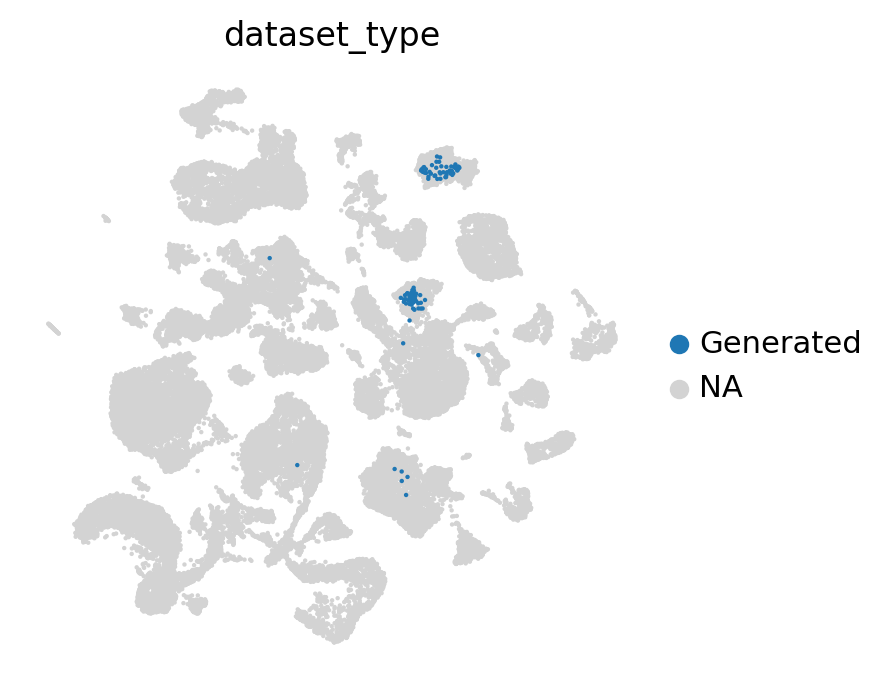

In [22]:
sc.pl.umap(adata_merged[adata_merged.obs.dataset_type=="Real"], color="mouse.id")
sc.pl.umap(adata_merged[adata_merged.obs.dataset_type=="Real"], color="tissue")
sc.pl.umap(adata_merged, color="dataset_type", groups="Generated", s=10)

## SINGLE CONDITION - tissue

In [23]:
# Pick condition 
covariates_tissue = 'Bladder'

condition_id_clus = dataset.id2cov["tissue"][covariates_tissue]

adata_cond = adata_original[adata_original.obs.tissue==covariates_tissue]

n_to_generate = adata_cond.shape[0]

classes = {"tissue": condition_id_clus*torch.ones(n_to_generate).long(), 
           "mouse.id": condition_id_mouse_id*torch.ones(n_to_generate).long()}

classes_str = {"tissue": [covariates_tissue for n in range(n_to_generate)], 
           "mouse.id": [covariates_mouse_id for n in range(n_to_generate)]}

log_size_factors = torch.log(torch.tensor(adata_cond.layers["X_counts"].sum(1))).cuda()

In [24]:
X_generated_tissue = generative_model.sample(batch_size=n_to_generate,
                                        n_sample_steps=100, 
                                        theta_covariate="tissue", 
                                        size_factor_covariate="mouse.id",
                                        conditioning_covariates=["tissue"],
                                        covariate_indices=classes, 
                                        log_size_factor=log_size_factors)

adata_generated_tissue = sc.AnnData(X=X_generated_tissue.cpu().numpy())

In [25]:
adata_merged_tissue = join_real_generated(adata_original, adata_generated_tissue, True, classes_str, ["tissue", "mouse.id"])

In [26]:
sc.pp.neighbors(adata_merged_tissue)
sc.tl.umap(adata_merged_tissue)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python

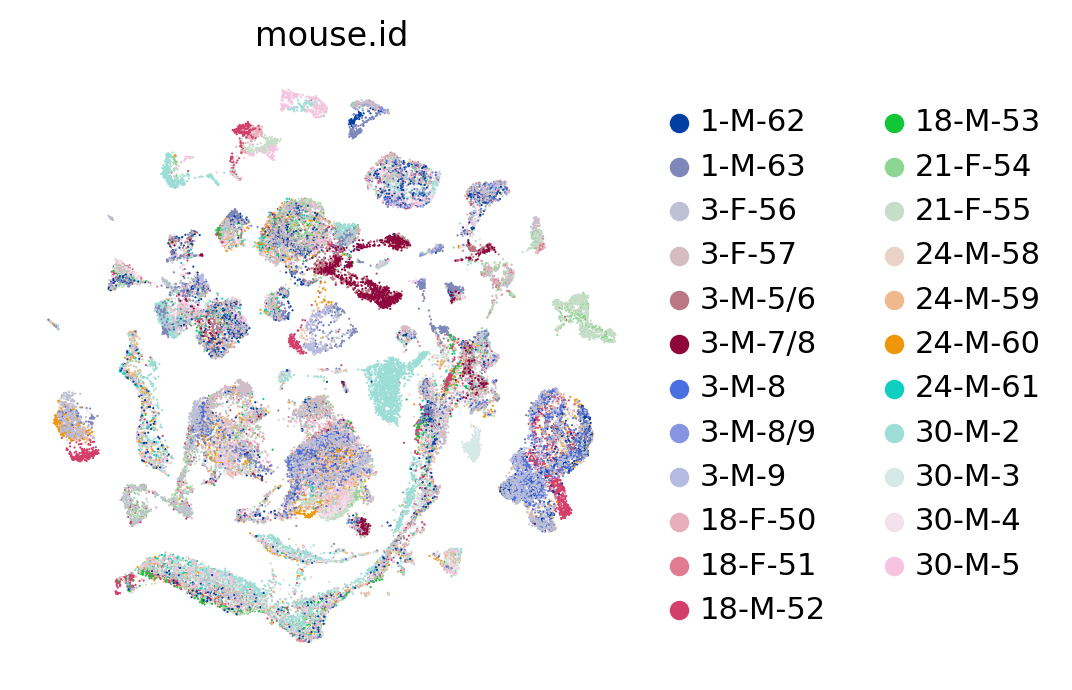

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python

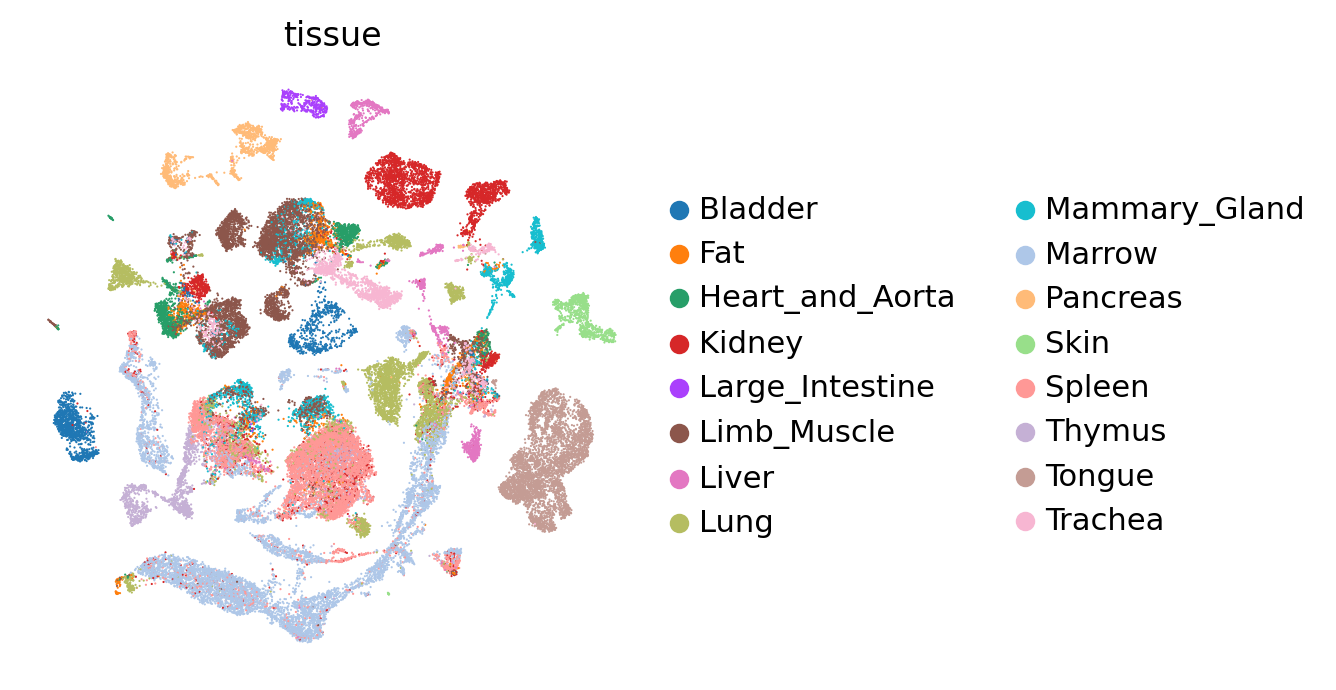

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


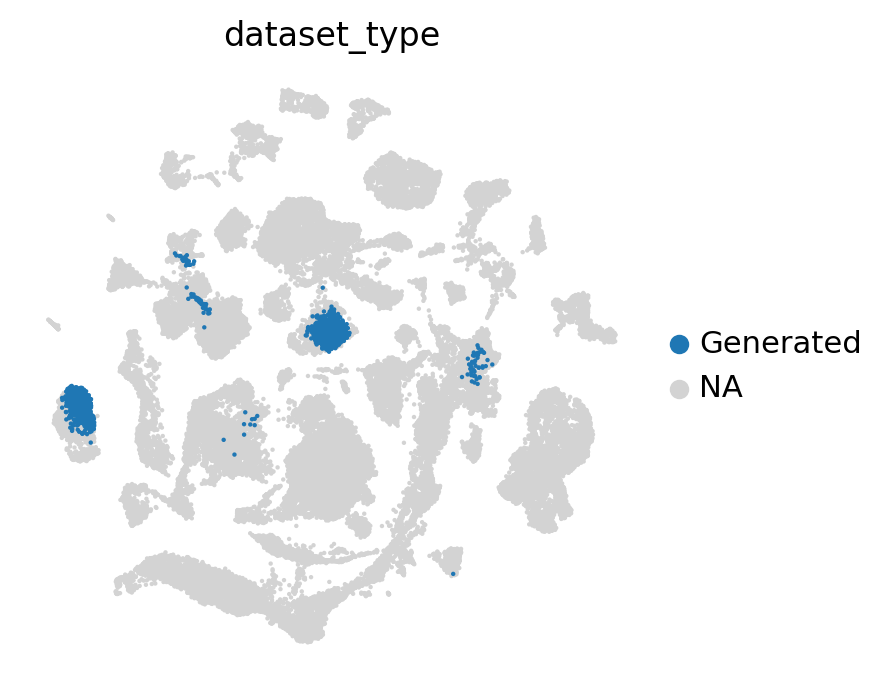

In [27]:
sc.pl.umap(adata_merged_tissue[adata_merged_tissue.obs.dataset_type=="Real"], color="mouse.id")
sc.pl.umap(adata_merged_tissue[adata_merged_tissue.obs.dataset_type=="Real"], color="tissue")
sc.pl.umap(adata_merged_tissue, color="dataset_type", groups="Generated", s=10)

## SINGLE CONDITION - batch

In [28]:
# Pick condition 
covariates_mouse_id = '3-F-56'

condition_id_mouse_id = dataset.id2cov["mouse.id"][covariates_mouse_id]

adata_cond = adata_original[adata_original.obs["mouse.id"]==covariates_mouse_id]
n_to_generate = adata_cond.shape[0]

classes = {"tissue": condition_id_clus*torch.ones(n_to_generate).long(), 
           "mouse.id": condition_id_mouse_id*torch.ones(n_to_generate).long()}

classes_str = {"tissue": [covariates_tissue for n in range(n_to_generate)], 
           "mouse.id": [covariates_mouse_id for n in range(n_to_generate)]}

log_size_factors = torch.log(torch.tensor(adata_cond.layers["X_counts"].sum(1))).cuda()

In [29]:
X_generated_mouse_id = generative_model.sample(batch_size=n_to_generate,
                                        n_sample_steps=2, 
                                        theta_covariate="tissue", 
                                        size_factor_covariate="mouse.id",
                                        conditioning_covariates=["mouse.id"],
                                        covariate_indices=classes, 
                                        log_size_factor=log_size_factors)

adata_generated_mouse_id = sc.AnnData(X=X_generated_mouse_id.cpu().numpy())

In [30]:
adata_merged_mouse_id = join_real_generated(adata_original, adata_generated_mouse_id, True, classes_str, ["tissue", "mouse.id"])

In [31]:
sc.pp.neighbors(adata_merged_mouse_id)
sc.tl.umap(adata_merged_mouse_id)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python

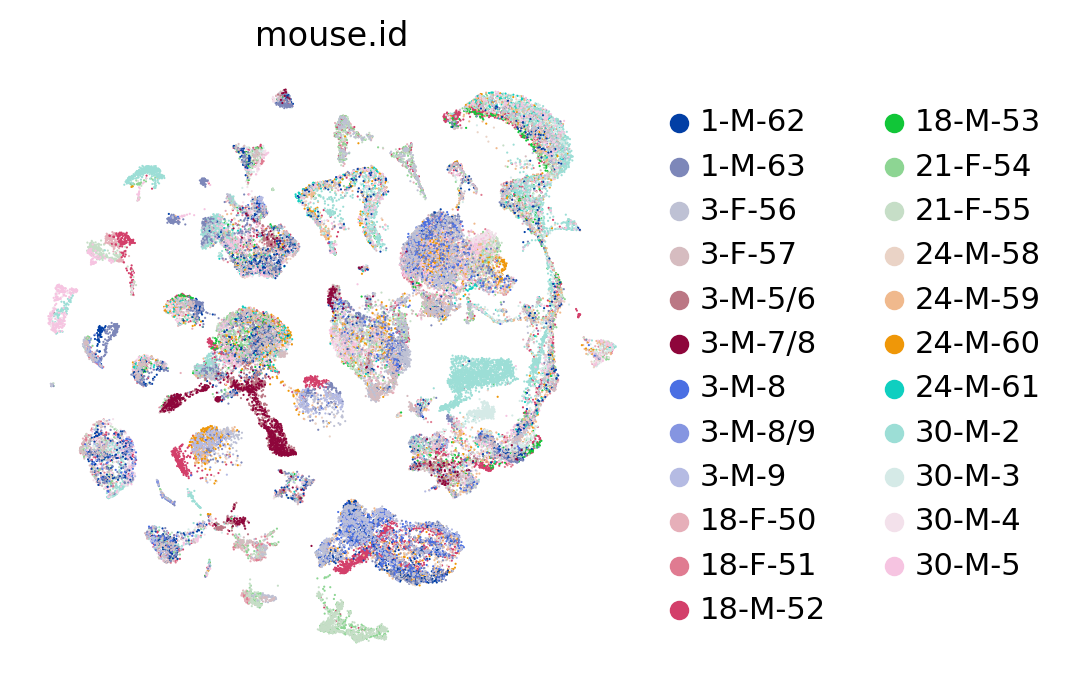

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python

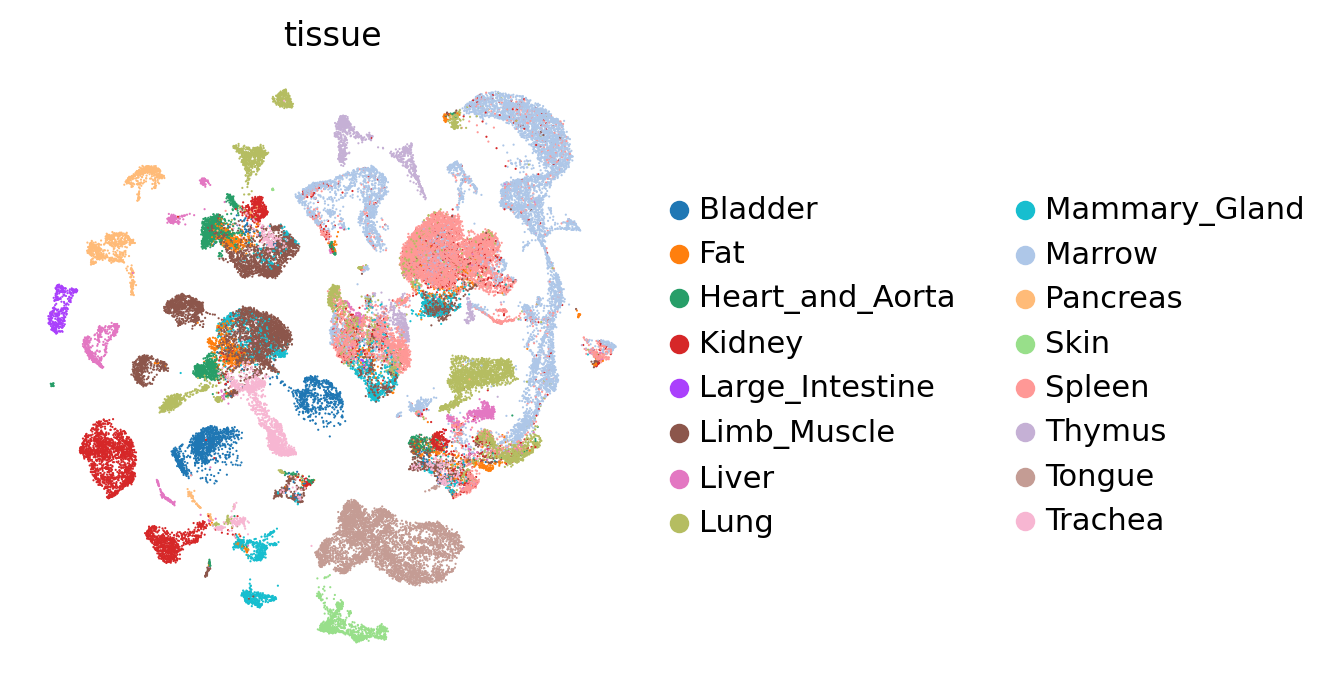

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


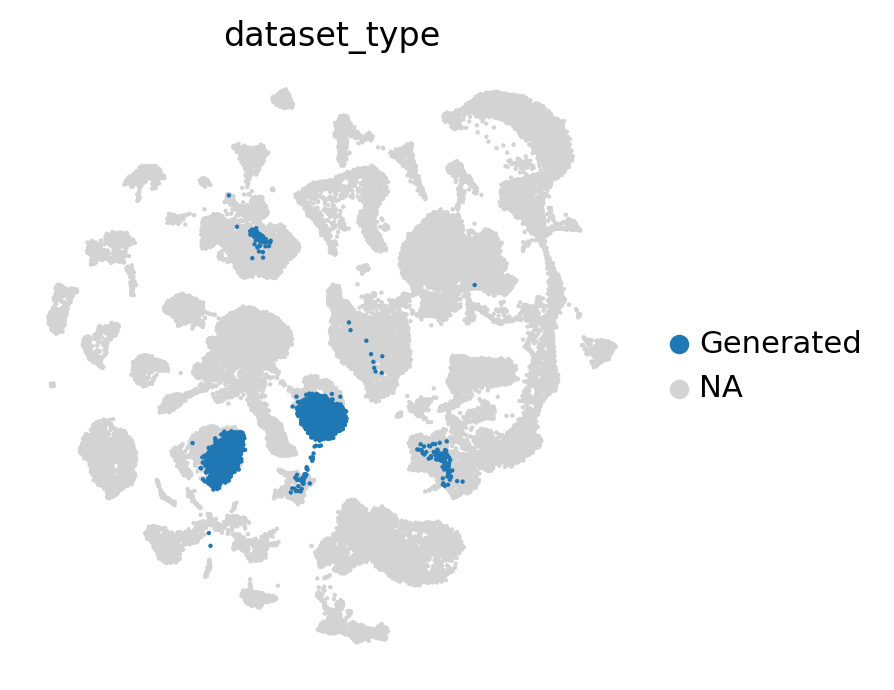

In [32]:
sc.pl.umap(adata_merged_mouse_id[adata_merged_mouse_id.obs.dataset_type=="Real"], color="mouse.id")
sc.pl.umap(adata_merged_mouse_id[adata_merged_mouse_id.obs.dataset_type=="Real"], color="tissue")
sc.pl.umap(adata_merged_mouse_id, color="dataset_type", groups="Generated", s=10)

## UNCONDITIONAL

In [33]:
index_range

NameError: name 'index_range' is not defined

In [ ]:
num_indices = 17000
index_range = len(X)

# Generate random dummy indices without replacement
indices = random.sample(range(index_range), num_indices)
adata_indices = adata_original[indices]

classes_tissue_str =  list(adata_indices.obs.tissue)
classes_tissue = torch.tensor([dataset.id2cov["tissue"][c] for  c in classes_tissue_str]).cuda()

classes_mouse_id_str =  list(adata_indices.obs["mouse.id"])
classes_mouse_id = torch.tensor([dataset.id2cov["mouse.id"][c] for  c in classes_mouse_id_str]).cuda()

classes_str = {"tissue": classes_tissue_str,
                  "mouse.id": classes_mouse_id_str}


log_size_factors = torch.log(torch.tensor(adata_indices.layers["X_counts"].sum(1))).cuda()

In [ ]:
X_generated_uncond = generative_model.sample(batch_size=num_indices,
                                            n_sample_steps=2, 
                                            theta_covariate="tissue", 
                                            size_factor_covariate="mouse.id",
                                            conditioning_covariates=["tissue"],
                                            covariate_indices=None, 
                                            log_size_factor=log_size_factors, 
                                            unconditional=True)

X_generated_uncond = X_generated_uncond.to("cpu")

adata_generated_uncond = sc.AnnData(X=X_generated_uncond.cpu().numpy())

In [ ]:
adata_merged_uncond = join_real_generated(adata_original, adata_generated_uncond, True, classes_str, ["tissue", "mouse.id"])

In [ ]:
sc.pp.neighbors(adata_merged_uncond)
sc.tl.umap(adata_merged_uncond)

In [ ]:
sc.pl.umap(adata_merged_uncond[adata_merged_uncond.obs.dataset_type=="Real"], color="mouse.id")
sc.pl.umap(adata_merged_uncond[adata_merged_uncond.obs.dataset_type=="Real"], color="tissue")
sc.pl.umap(adata_merged_uncond, color="dataset_type", groups="Generated", s=10)